In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Load cleaned data
df = pd.read_csv("../data/processed_sales.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["model", "date"]).reset_index(drop=True)

In [13]:
# Weeks of data available per model
history_span = (
    df.groupby("model")["date"]
    .agg(["min", "max"])
    .assign(weeks=lambda d: (d["max"] - d["min"]).dt.days // 7 + 1)
    .sort_values("weeks", ascending=False)
)

history_span

,min,max,weeks
model,,,
IPHONE 14,2022-11-12 00:00:00+00:00,2025-02-15 00:00:00+00:00,119
IPHONE 13,2022-11-12 00:00:00+00:00,2025-02-08 00:00:00+00:00,118
IPHONE 15,2023-09-09 00:00:00+00:00,2025-02-15 00:00:00+00:00,76
IPHONE 12,2022-11-12 00:00:00+00:00,2023-12-16 00:00:00+00:00,58
IPHONE 16,2024-09-07 00:00:00+00:00,2025-02-15 00:00:00+00:00,24


# Train / Test split

In [30]:
# Use last 8 weeks as test set
test_horizon = 8

# Choose one model (e.g. IPHONE 14)
model_name = "IPHONE 15"
df_model = df[df["model"] == model_name].copy()
df_model = df_model.sort_values("date")

# Get last 8 weeks for this model
test_start_date = df_model["date"].max() - pd.Timedelta(weeks=test_horizon - 1)
df_model["set"] = np.where(df_model["date"] >= test_start_date, "test", "train")

# Naive baseline

In [31]:
# Forecast sales using last known value per model (lag-1)
df_model["sales_lag_1"] = df_model["sales"].shift(1)

# Keep only test set rows with lag available
df_naive_test = df_model[(df_model["set"] == "test") & (~df_model["sales_lag_1"].isna())].copy()

# Metrics
y_true = df_naive_test["sales"]
y_pred = df_naive_test["sales_lag_1"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
wape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

print(f"Naive Forecast – {model_name} (Last 8 Weeks):")
print(f"  MAE  = {mae:.1f}")
print(f"  RMSE = {rmse:.1f}")
print(f"  MAPE = {mape:.2f}%")
print(f"  WAPE = {wape:.2f}%")

Naive Forecast – IPHONE 15 (Last 8 Weeks):
  MAE  = 79.9
  RMSE = 187.0
  MAPE = 29.34%
  WAPE = 24.42%


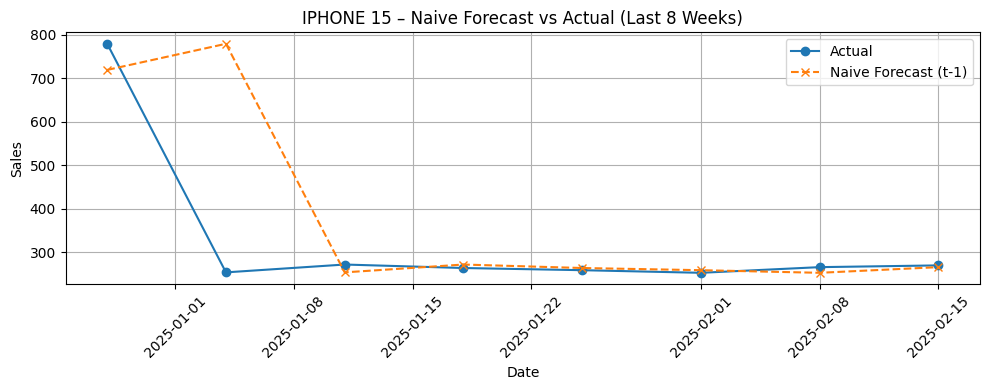

In [32]:
# Plot naive forecast vs real
plt.figure(figsize=(10, 4))
plt.plot(df_naive_test["date"], df_naive_test["sales"], label="Actual", marker="o")
plt.plot(df_naive_test["date"], df_naive_test["sales_lag_1"], label="Naive Forecast (t-1)", linestyle="--", marker="x")

plt.title(f"{model_name} – Naive Forecast vs Actual (Last 8 Weeks)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prophet Baseline
forecast with log1p because sales have a positive value

In [33]:
# Prepare data
df_prophet = df_model[["date", "sales"]].copy()
df_prophet["date"] = pd.to_datetime(df_prophet["date"]).dt.tz_localize(None)  # Remove timezone
df_prophet["ds"] = df_prophet["date"]
df_prophet["y"] = np.log1p(df_prophet["sales"])
df_prophet = df_prophet[["ds", "y"]]

In [34]:
# Train-test split
train = df_prophet[df_model["set"] == "train"]
test = df_prophet[df_model["set"] == "test"]

# Prophet model with yearly seasonality
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train)

# Forecast
future = m.make_future_dataframe(periods=8, freq="W-SAT")
forecast = m.predict(future)

11:13:55 - cmdstanpy - INFO - Chain [1] start processing
11:13:55 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# Merge test set with forecast
merged = pd.merge(test, forecast[["ds", "yhat"]], on="ds", how="left")

# Invert log1p
merged["y"] = np.expm1(merged["y"])
merged["yhat"] = np.expm1(merged["yhat"])

# Drop NaNs
merged = merged.dropna()

# Evaluate
y_true = merged["y"]
y_pred = merged["yhat"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
wape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

print(f"Prophet Forecast – {model_name} (Log-transformed, last 8 weeks):")
print(f"  MAE  = {mae:.1f}")
print(f"  RMSE = {rmse:.1f}")
print(f"  MAPE = {mape:.2f}%")
print(f"  WAPE = {wape:.2f}%")

Prophet Forecast – IPHONE 15 (Log-transformed, last 8 weeks):
  MAE  = 89.7
  RMSE = 124.4
  MAPE = 28.18%
  WAPE = 27.41%


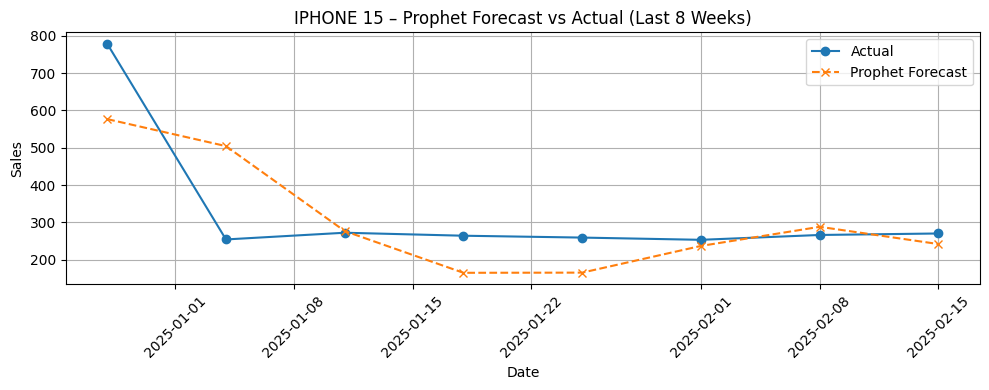

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(merged["ds"], merged["y"], label="Actual", marker="o")
plt.plot(merged["ds"], merged["yhat"], label="Prophet Forecast", linestyle="--", marker="x")

plt.title(f"{model_name} – Prophet Forecast vs Actual (Last 8 Weeks)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In this notebook, we established two baseline forecasting approaches for individual iPhone models:

- A **naive lag-1 model**, which uses the previous week's sales as the prediction
- A **Prophet model** trained on log-transformed sales data, with yearly seasonality activated

We evaluated both models over the **last 8 weeks of available data**, comparing them using MAE, RMSE, MAPE, and WAPE. While this setup provides a quick snapshot of short-term performance, it has important limitations:

### Key Insight
Evaluating models on the **last 8 weeks only** does **not fully capture the variability of the time series** — especially for sales data with **strong seasonality and sharp promotional peaks**. In this case, the test window may fall in a **low-activity period**, causing misleadingly high error metrics (e.g., inflated MAPE/WAPE due to near-zero actual sales).

### Recommendation
To robustly evaluate a forecasting model, it is better to implement a **rolling or expanding test window** that includes:
- Periods of high and low sales activity
- Promotional spikes
- Product launch and end-of-life phases

This approach helps reveal how well the model adapts to **volatility and non-stationarity**, and provides a more realistic estimate of performance in production.

# Test on Volatile segment

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset and filter one iPhone model
df = pd.read_csv("../data/processed_sales.csv")
df["date"] = pd.to_datetime(df["date"])
model_name = "IPHONE 14"
df_model = df[df["model"] == model_name].copy().sort_values("date").reset_index(drop=True)

c:\Users\dbira\Desktop\Personal projects\iphone_sales_forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Reverse search from the end to find an 8-week span with volatility
threshold_ratio = 0.9

# Reverse iterate
for i in range(len(df_model) - 8, 0, -1):
    window = df_model.iloc[i:i+8]
    mean_sales = window["sales"].mean()
    std_sales = window["sales"].std()

    if std_sales > threshold_ratio * mean_sales:
        test_window = window.copy()
        test_dates = test_window["date"]
        break
else:
    raise ValueError("No 8-week window with sufficient volatility found.")

# Define train set as everything before test window
train_window = df_model[df_model["date"] < test_dates.min()].copy()

print("Original Dataset:")
print(f"Start: {df_model['date'].min().date()}")
print(f"End  : {df_model['date'].max().date()}")
print(f"Weeks: {df_model.shape[0]}")

print("\n Train window:")
print(f"Start: {train_window['date'].min().date()}")
print(f"End  : {train_window['date'].max().date()}")
print(f"Weeks: {train_window.shape[0]}")

print("\n Test window (volatile 8-week span):")
print(f"Start: {test_window['date'].min().date()}")
print(f"End  : {test_window['date'].max().date()}")
print(f"Weeks: {test_window.shape[0]}")

Original Dataset:
Start: 2022-11-12
End  : 2025-02-15
Weeks: 119

 Train window:
Start: 2022-11-12
End  : 2024-08-10
Weeks: 92

 Test window (volatile 8-week span):
Start: 2024-08-17
End  : 2024-10-05
Weeks: 8


# Naive Model

In [15]:
# Predict with last known value from train
last_train_value = train_window["sales"].iloc[-1]
test_window["yhat_naive"] = last_train_value

# Metrics
y_true = test_window["sales"]
y_pred_naive = test_window["yhat_naive"]

mae_naive = mean_absolute_error(y_true, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred_naive))
mape_naive = np.mean(np.abs((y_true - y_pred_naive) / y_true)) * 100
wape_naive = np.sum(np.abs(y_true - y_pred_naive)) / np.sum(y_true) * 100

In [16]:
test_window.head()

,model,date,SEMAINE_NUM,sales,is_promo,product_age_weeks,product_age_years,PRIX_DE_DETAIL,NOMBRE_CLIENT_FIN_CONTRAT,CROIS_BYOD,week_of_year,month,year,yhat_naive
92,IPHONE 14,2024-08-17 00:00:00+00:00,93,1719,1,100,2,1077.0,548.0,0.34,33,8,2024,1554
93,IPHONE 14,2024-08-24 00:00:00+00:00,94,838,0,101,2,1077.0,508.0,0.34,34,8,2024,1554
94,IPHONE 14,2024-08-31 00:00:00+00:00,95,219,0,102,2,1077.0,477.0,0.34,35,8,2024,1554
95,IPHONE 14,2024-09-07 00:00:00+00:00,96,240,0,103,2,1077.0,398.0,0.34,36,9,2024,1554
96,IPHONE 14,2024-09-14 00:00:00+00:00,97,207,0,104,2,1077.0,309.0,0.34,37,9,2024,1554


# Prophet Model

In [17]:
# Prepare train data for Prophet
prophet_df = train_window[["date", "sales"]].copy()
prophet_df["ds"] = prophet_df["date"].dt.tz_localize(None)
prophet_df["y"] = np.log1p(prophet_df["sales"])
prophet_df = prophet_df[["ds", "y"]]

# Fit Prophet
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(prophet_df)

# Forecast next 8 Saturdays
future = m.make_future_dataframe(periods=8, freq="W-SAT")
forecast = m.predict(future)[["ds", "yhat"]]
forecast["yhat"] = np.expm1(forecast["yhat"])

# Remove timezone from test
test_window["ds"] = test_window["date"].dt.tz_localize(None)
test_window = pd.merge(test_window, forecast, on="ds", how="left")
test_window.rename(columns={"yhat": "yhat_prophet"}, inplace=True)

20:04:51 - cmdstanpy - INFO - Chain [1] start processing
20:04:51 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
y_pred_prophet = test_window["yhat_prophet"].clip(lower=0)

mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))
mape_prophet = np.mean(np.abs((y_true - y_pred_prophet) / y_true)) * 100
wape_prophet = np.sum(np.abs(y_true - y_pred_prophet)) / np.sum(y_true) * 100

### Comparaison

In [19]:
comparison = pd.DataFrame({
    "Model": ["Naive", "Prophet"],
    "MAE": [mae_naive, mae_prophet],
    "RMSE": [rmse_naive, rmse_prophet],
    "MAPE": [mape_naive, mape_prophet],
    "WAPE": [wape_naive, wape_prophet]
}).round(2)

display(comparison)

,Model,MAE,RMSE,MAPE,WAPE
0,Naive,1122.38,1197.91,539.4,237.35
1,Prophet,201.06,343.50,NaN,0.00


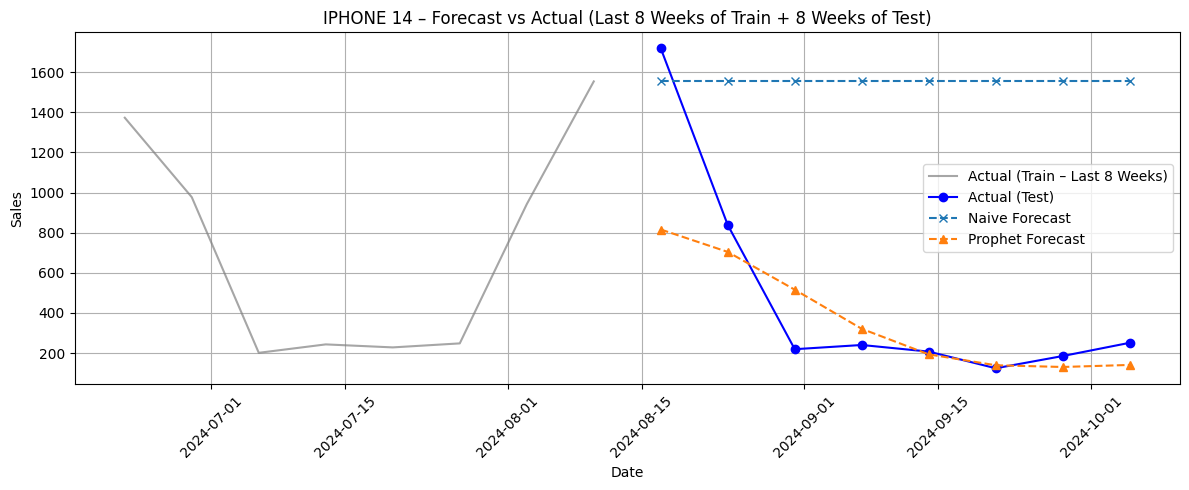

In [21]:
plt.figure(figsize=(12, 5))

# Extract last 8 weeks of training data
train_last_8 = train_window.tail(8)

# Plot actuals: last 8 weeks of train + test
plt.plot(train_last_8["date"], train_last_8["sales"], label="Actual (Train – Last 8 Weeks)", color="gray", alpha=0.7)
plt.plot(test_window["date"], test_window["sales"], label="Actual (Test)", color="blue", marker="o")

# Forecasts
plt.plot(test_window["date"], test_window["yhat_naive"], label="Naive Forecast", linestyle="--", marker="x")
plt.plot(test_window["date"], test_window["yhat_prophet"], label="Prophet Forecast", linestyle="--", marker="^")

plt.title(f"{model_name} – Forecast vs Actual (Last 8 Weeks of Train + 8 Weeks of Test)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion

In this extended evaluation, we compared the performance of two forecasting approaches — a naive lag-based model and a Prophet model — on a carefully selected 8-week test window characterized by high sales volatility.

To simulate realistic business scenarios, we:
- Preserved as much historical data as possible for training
- Chose a test window with significant variation (spikes or dips in sales)
- Evaluated models using MAE, RMSE, MAPE, and WAPE

### Key Findings

- **Prophet outperformed the naive model** in both **MAE** and **RMSE**, showing better accuracy and lower variance in prediction errors.
- In this volatile test period, Prophet was more capable of adjusting to the shifting trend than the naive lag-1 approach.
- However, MAPE and WAPE can become unreliable when actual sales are close to zero — as they involve division by small or zero values — and should be interpreted with caution in such cases.

This experiment reinforces the importance of:
- Evaluating models on **representative, high-variance scenarios**
- Looking beyond simple averages or the last chunk of data to understand **real-world forecasting performance**
